### Image Object Detection Using Tensorflow-trained Classifier ###


### Import necessary libraries 

In [1]:
from platform import python_version

print(python_version())

3.5.6


In [2]:
import google.protobuf
print (google.protobuf.__version__)

3.12.4


In [3]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [4]:
# Adjust the following path relative to this notebook
sys.path.append("D:/Shreya_docs/models/research/object_detection")
from utils import ops as utils_ops

print(tf.__version__)

1.15.0


### Import the object detection module.

In [5]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# Env setup

In [6]:
# This is needed to display the images.
%matplotlib inline

Patches:

In [7]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

# Model preparation 

## Variables

Model is exported using the `export_inference_graph.py` from the object_detection directory. We have exported the model by running command in the anaconda terminal.


In [8]:
# Path to frozen detection graph relative to this notebook. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = 'D:/Shreya_docs/models/research/object_detection/inference_graph/frozen_inference_graph.pb'

# Path to label map relatvie to this notebook.  List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'D:/Shreya_docs/models/research/object_detection/training/obj-detection.pbtxt'

NUM_CLASSES = 3

### Load a (frozen) Tensorflow model into memory.

In [9]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map

In [10]:
# List of the strings that is used to add correct label for each box.


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

### Getting the test images into an array and does reshaping too

In [11]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

### Now, let's detect our Test images ..

# Detection

In [12]:
# Test images must be named image1.jpg, image2.jpg... Adjust the index to predict on the target image.
PATH_TO_TEST_IMAGES_DIR = 'D:/Shreya_docs/models/research/object_detection/test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)).replace("\\","/") for i in range(13,23) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

### Let's print the path of test images ..

In [13]:
TEST_IMAGE_PATHS

['D:/Shreya_docs/models/research/object_detection/test_images/image13.jpg',
 'D:/Shreya_docs/models/research/object_detection/test_images/image14.jpg',
 'D:/Shreya_docs/models/research/object_detection/test_images/image15.jpg',
 'D:/Shreya_docs/models/research/object_detection/test_images/image16.jpg',
 'D:/Shreya_docs/models/research/object_detection/test_images/image17.jpg',
 'D:/Shreya_docs/models/research/object_detection/test_images/image18.jpg',
 'D:/Shreya_docs/models/research/object_detection/test_images/image19.jpg',
 'D:/Shreya_docs/models/research/object_detection/test_images/image20.jpg',
 'D:/Shreya_docs/models/research/object_detection/test_images/image21.jpg',
 'D:/Shreya_docs/models/research/object_detection/test_images/image22.jpg']

### Now let's run it on each test image and show the results:

In [14]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

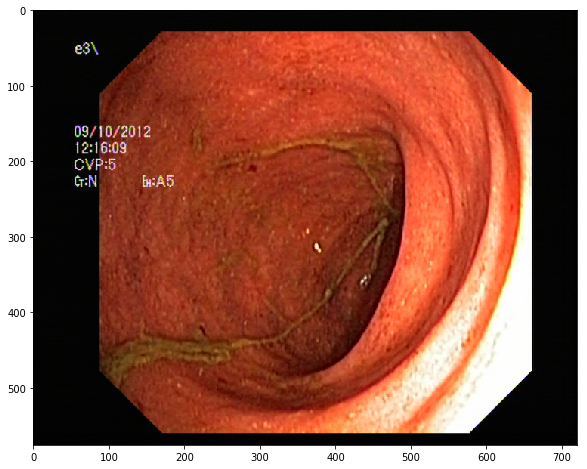

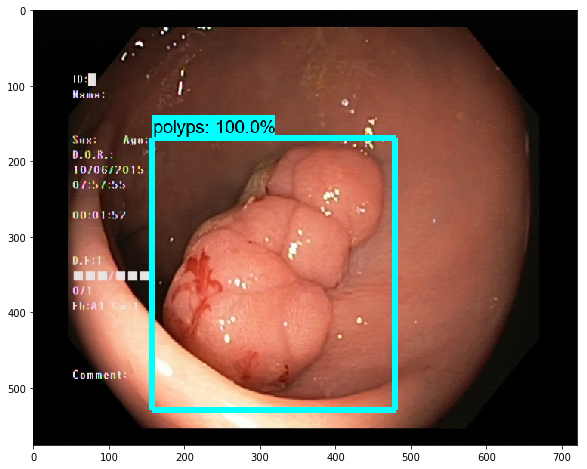

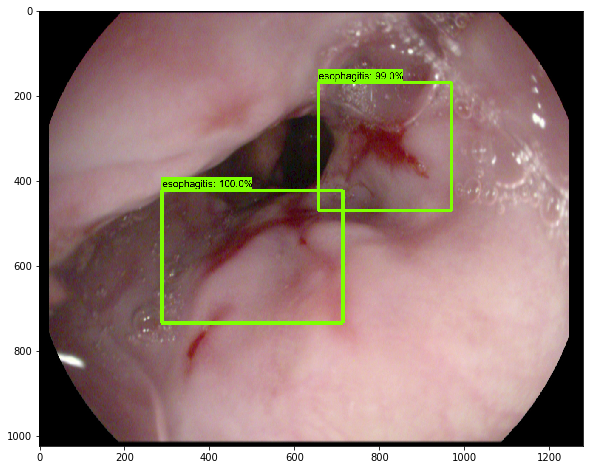

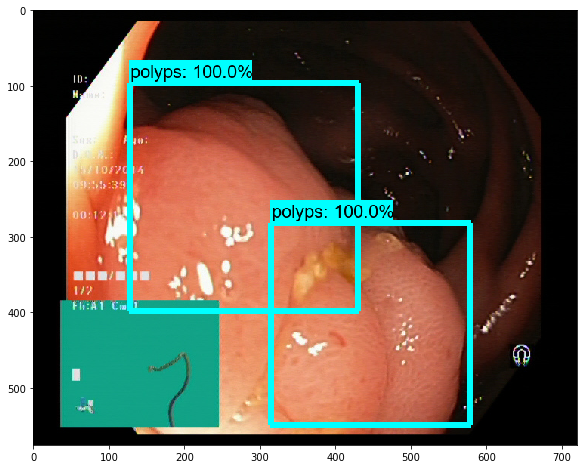

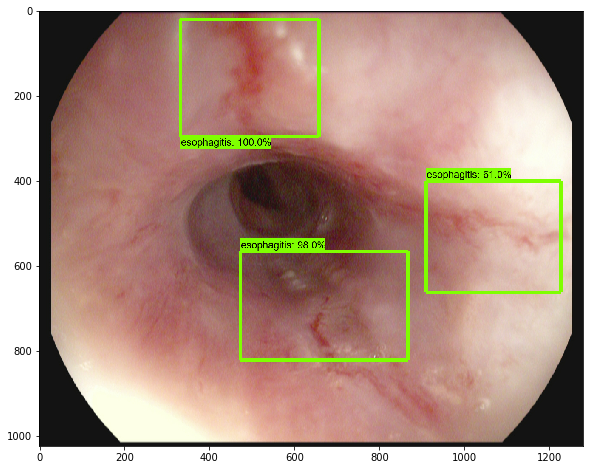

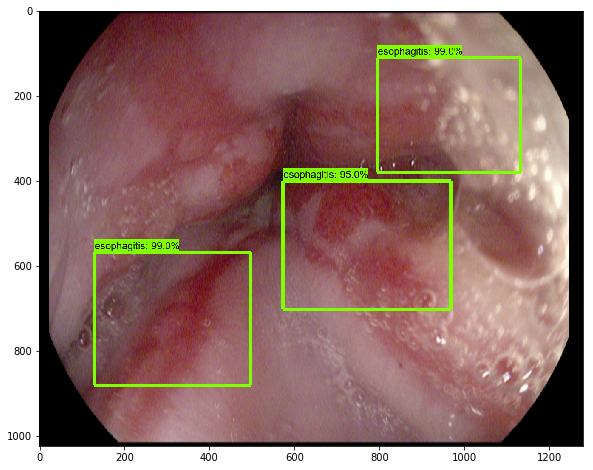

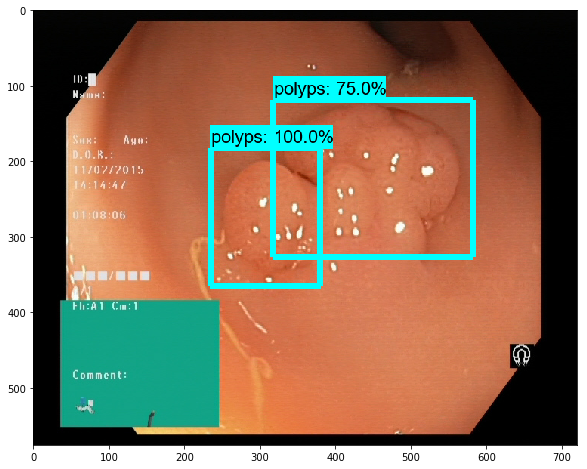

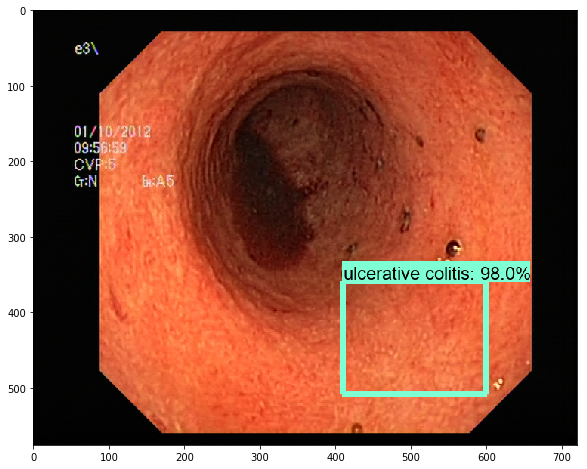

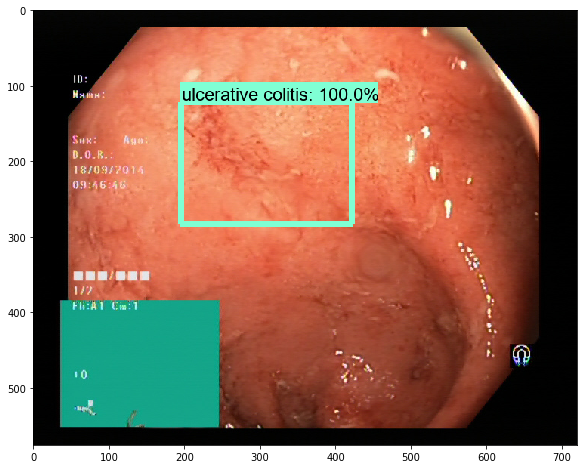

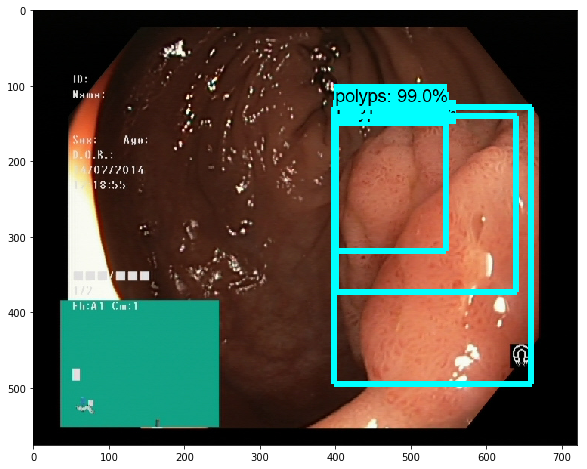

In [15]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
 

### Let's check the dataset ..

In [16]:
import pandas as pd
train_df = pd.read_csv(r'D:\Shreya_docs\models\research\object_detection\data\train_labels.csv')
train_df.head()

filename  width  height        class  xmin  ymin  xmax  ymax
0    esophagitis1.jpg   1280    1024  esophagitis   333   622   612   834
1   esophagitis10.jpg   1280    1024  esophagitis   800   125  1153   383
2  esophagitis100.jpg   1280    1024  esophagitis   384   571   787   866
3  esophagitis101.jpg   1280    1024  esophagitis   923   188  1224   478
4  esophagitis102.jpg   1280    1024  esophagitis   740   203  1114   522

## Ground Truth and Predictions of every Test images ..

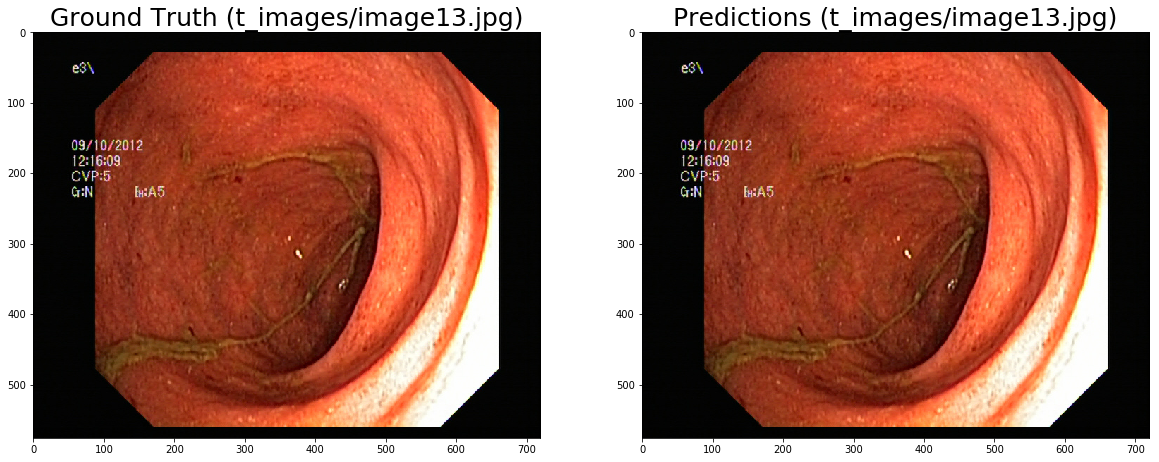

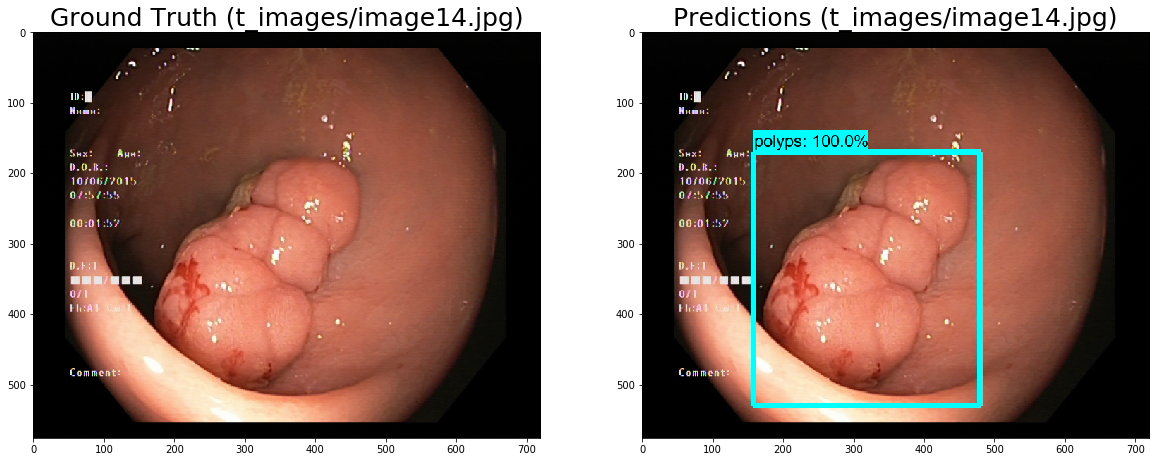

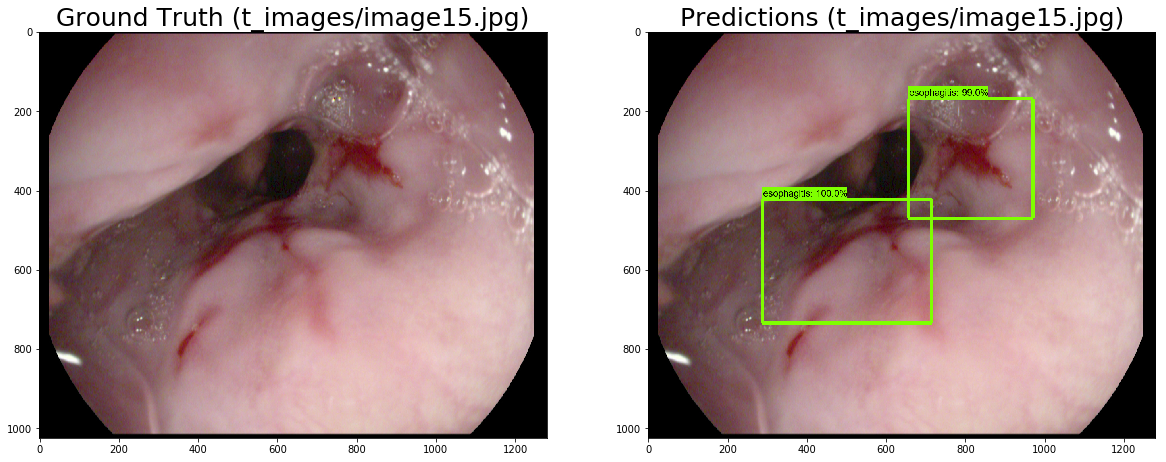

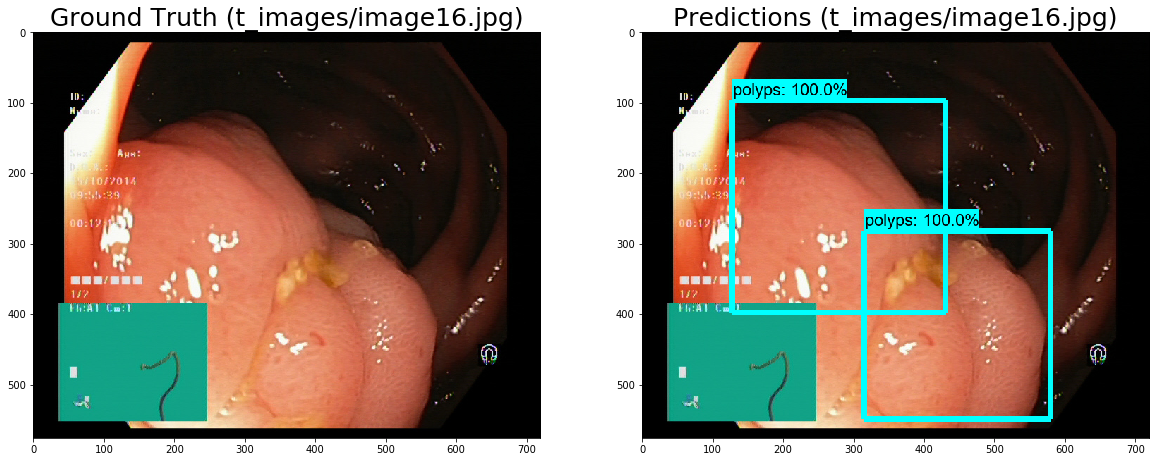

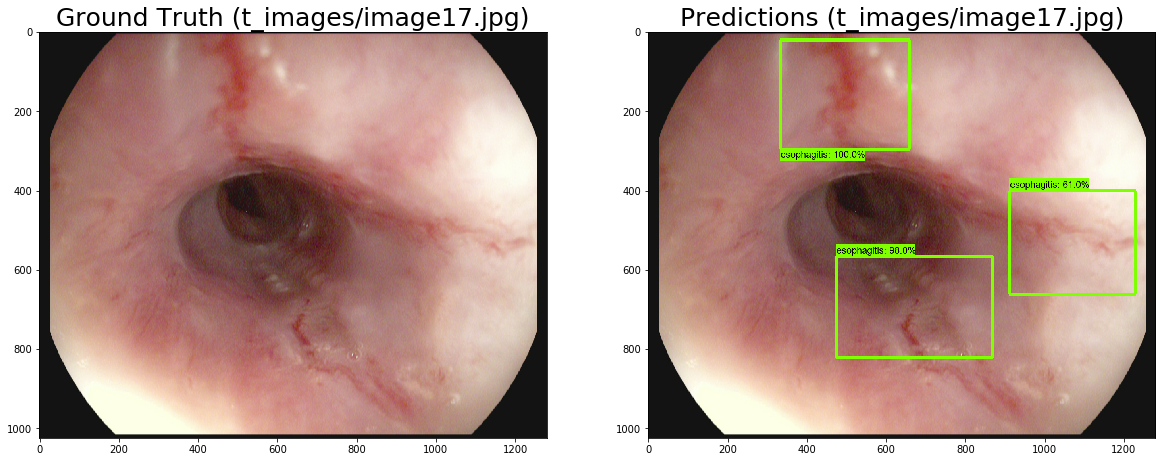

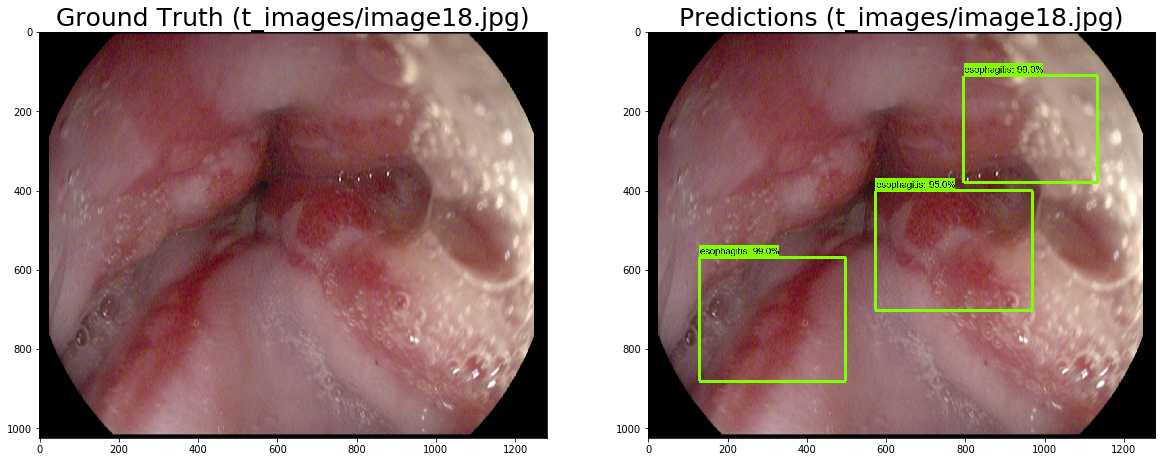

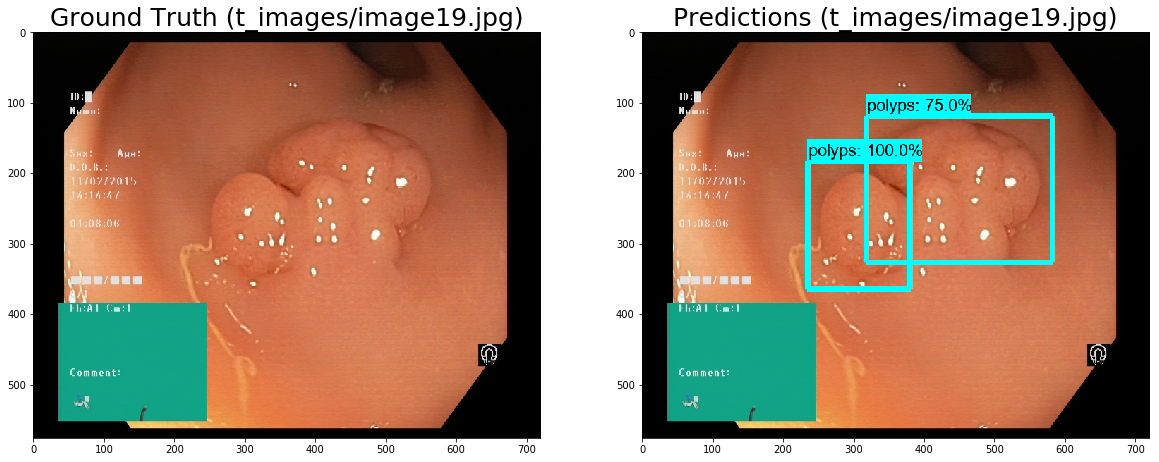

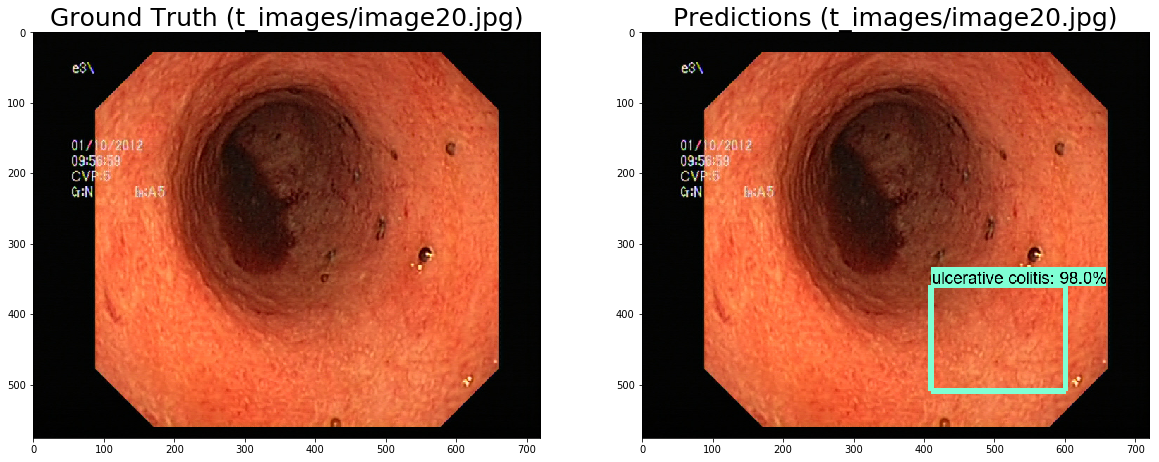

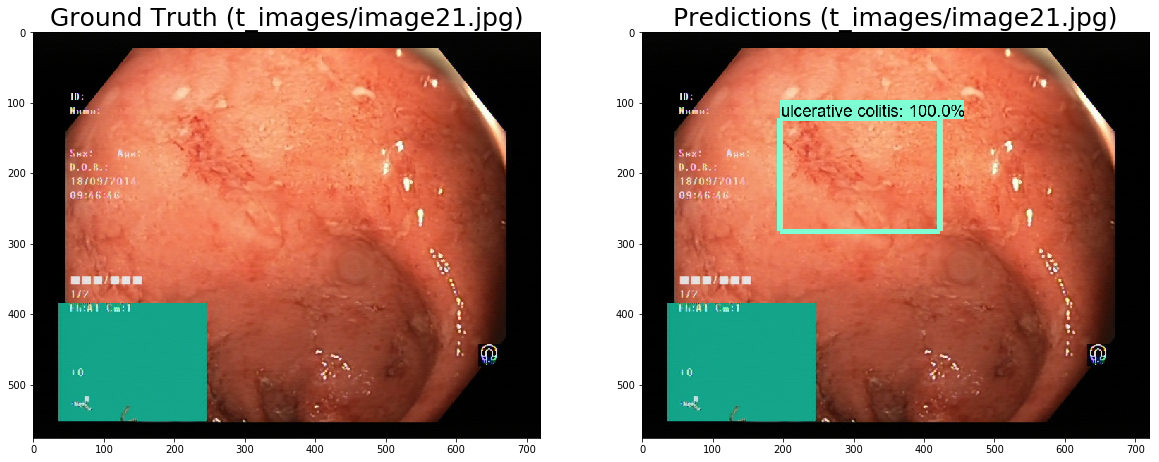

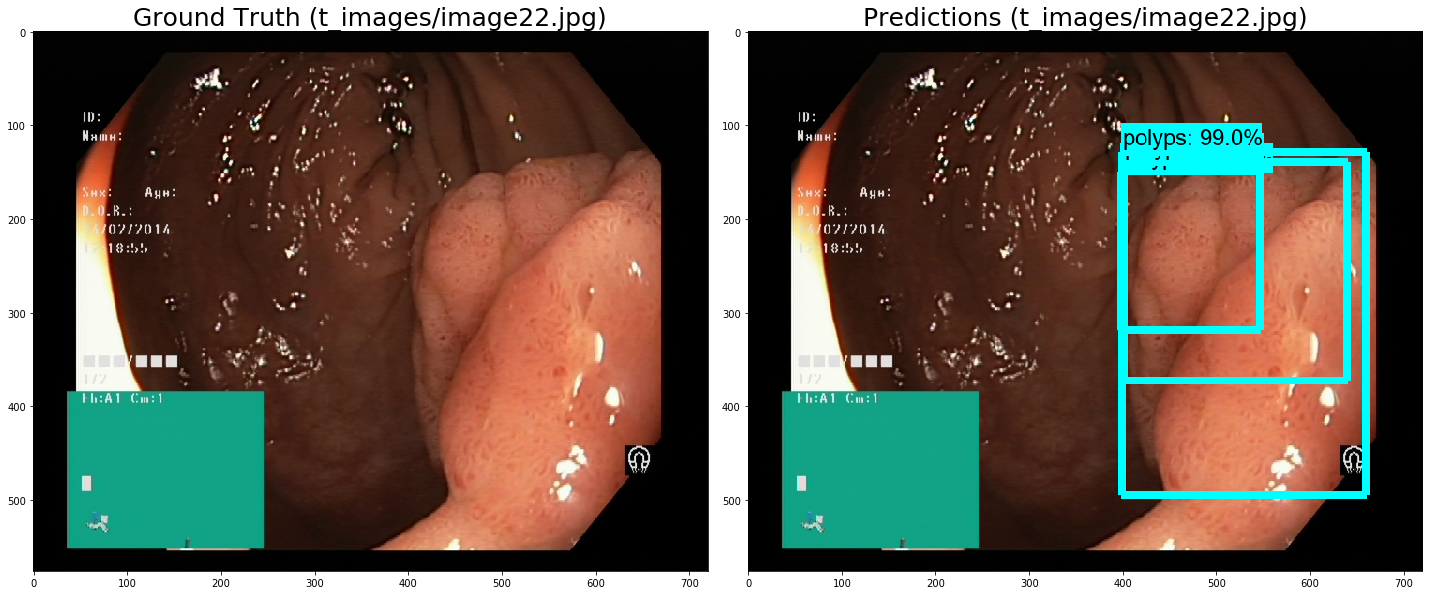

In [17]:
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    #image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    figure, (ax2, ax1) = plt.subplots(1, 2, figsize=(20,18))
# plots prediction
    ax1.set_title("Predictions (" + image_path[-20:] + ")", size=25)
    ax1.imshow(image_np)
    
# plots ground truth
    original = image
    ax2.set_title("Ground Truth (" + image_path[-20:] + ")", size=25)
    ax2.imshow(original)
    for _,row in train_df[train_df.filename == image_path[-20:]].iterrows():
        xmin = row.xmin
        xmax = row.xmax
        ymin = row.ymin
        ymax = row.ymax
        width = xmax - xmin
        height = ymax - ymin
# assign different color to different classes of objects
        if row["class"] == 'esophagitis':
            edgecolor = 'lawngreen'
            ax2.annotate('esophagitis', xy=(xmax-40,ymin+20), size=25)
        elif row["class"] == 'polyps':
            edgecolor = 'cyan'
            ax2.annotate('polyps', xy=(xmax-40,ymin+20), size=25)
        elif row["class"] == 'ulcerative colitis':
            edgecolor = 'aquamarine'
            ax2.annotate('ulcerative colitis', xy=(xmax-40,ymin+20), size=25)
# add bounding boxes to the image
        rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none', lw=6)
        ax2.add_patch(rect)
plt.tight_layout()
plt.show()